# Item importance evaluation
This notebook aims to find out the importance of each item in our dataset, so based on the infos we (might) find out, we may direct our efforts to an especific model...

In [1]:
import numpy as np
import pandas as pd
from utils import read_data, process_time, merge_data, promo_detector, promotionAggregation
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
import sys
import xgboost as xgb
import lightgbm as lgb
from datetime import datetime
from catboost import CatBoost, CatBoostRegressor, Pool, cv
plt.rcParams['figure.figsize'] = (45, 10.0) # set default size of plots

NUMBER_OF_LAGS = 4

sys.path.append("../../main/datasets/")
!ls  ../../main/datasets/

1.0v  1.0v.zip


In [2]:
infos, items, orders = read_data("../../main/datasets/")
print("Sanity checks...", infos.shape, items.shape, orders.shape)

Sanity checks... (10463, 3) (10463, 8) (2181955, 5)


## Preparing our dataset

In [3]:
# Changing our time signatures, 
# adding our promotion feature 
# and aggregating our data by weeks...
process_time(orders)
orders = promo_detector(orders)
df = promotionAggregation(orders, items)

In [4]:
def prepareOrders(orders, items):
    """This function is responsible for adding in our 'orders' dataframe
    the items that were not sold. THIS IS NOT MODULARIZED, THUS YOU
    SHOULD CHANGE THE CODE TO BETTER SUIT YOUR DATASET FEATURES
    """
    
    df = orders.copy()
    
    # Getting the IDs that were never sold
    not_sold_items = items[np.logical_not(
        items.itemID.isin(sorted(orders['itemID'].unique())))]

    new_rows = []
    weeks_database = orders['group_backwards'].unique()

    for idd in df['itemID'].unique():
        orders_id = df[df.itemID == idd]
        example = orders_id.iloc[0]

        # finding weeks without itemID sales
        weeks_id = orders_id['group_backwards'].unique()
        weeks_without_id = np.setdiff1d(weeks_database, weeks_id)

        # creating new row
        for w in weeks_without_id:
            new_rows.append({'itemID': idd,
                             'group_backwards': w,
                             'salesPrice_mean': 0,
                             'customerRating': example['customerRating'],
                             'category1': example['category1'],
                             'category2': example['category2'],
                             'category3': example['category3'],
                             'recommendedRetailPrice': example['recommendedRetailPrice'],
                             'orderSum': 0,
                             'manufacturer': example['manufacturer'],
                             'brand': example['brand'],
                             'promotion_mean': 0
                             })
    #  Adding rows in every week with the IDs of the
    # items that were never sold.
    df = df.append(new_rows)
    not_sold_orders = pd.DataFrame()
    for i in range(1, 14):
        aux = not_sold_items.copy()
        aux['group_backwards'] = i
        aux['salesPrice_mean'] = 0
        aux['promotion_mean'] = 0
        aux['orderSum'] = 0
        not_sold_orders = pd.concat([not_sold_orders, aux], axis=0)
    df = pd.concat([df, not_sold_orders], axis=0).sort_values(
        ['group_backwards', 'itemID'], ascending=[False, True], ignore_index=True)
    return df

In [5]:
df = prepareOrders(df, items)

## Calculating the relevance: Naive approach
At first glance, one might just guesstimate the relevance of an item by the sum of the products between the **number of orders in a given week** and the **mean of the price of the product in the given week**.

In [6]:
df['itemRelevance'] = df['orderSum'] * df['salesPrice_mean']
relevances = df.groupby('itemID', as_index=False).agg({'itemRelevance':'mean'})

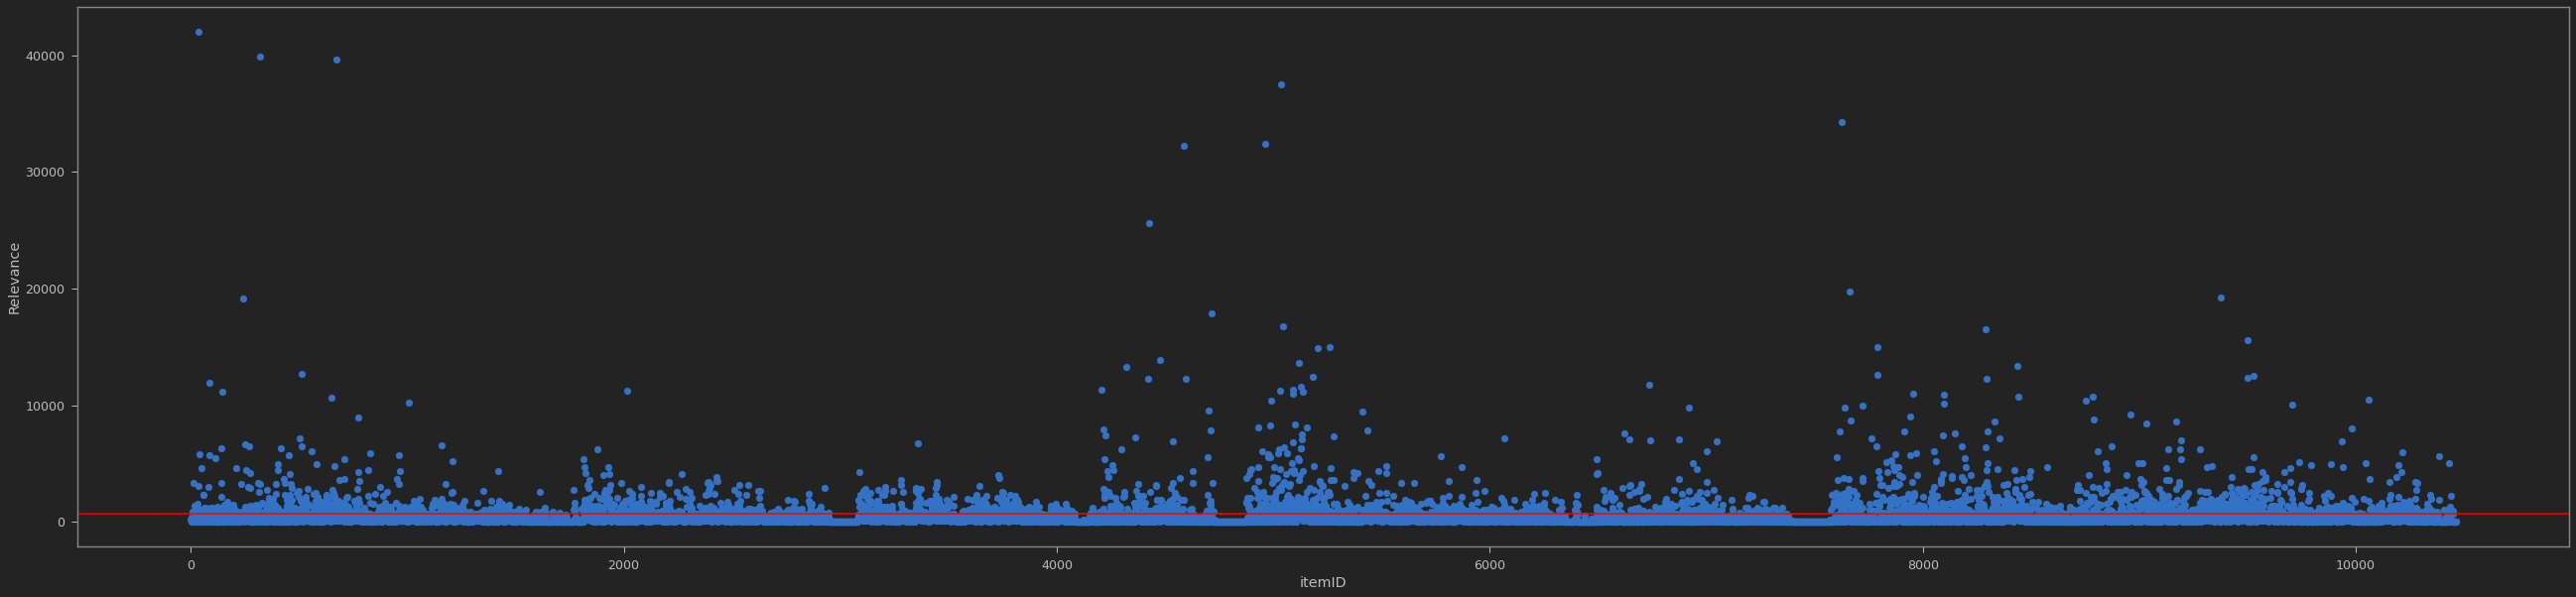

In [7]:
plt.xlabel('itemID')
plt.ylabel('Relevance')
plt.scatter(relevances['itemID'], relevances['itemRelevance'])
# plt.axhline(np.var(relevances[:, 1]), color="green")
plt.axhline(np.mean(relevances['itemRelevance']), color="red")

## Calculating the relevance: Enhanced approach
We might also try to guesstimate the relevance of items based in **how many weeks a given item is sold**. The main idea behind this approach is to try to eliminate the items that are sold just a few times, but due to its' price, have a high effect on the relevance. So, products that happen to be sold fewer times, will be linearly penalized.

In [8]:
# We'll get only the items of the train set.
df = df.drop(df.loc[df.group_backwards < 3].index)

In [9]:
# If an item is sold at least once in a given week...
# ... it will be 'flagged' with '1'

df['soldThisWeek'] = 0
df.loc[df.orderSum > 0, 'soldThisWeek'] = 1

# We'll sum all the flags, and they'll 
# mark how many weeks each item was sold.
itemSaleFreq = df.groupby('itemID', as_index=False).agg(
    {'soldThisWeek': 'sum'}).rename(columns={'soldThisWeek': 'weeklyFreq'})

df = pd.merge(df, itemSaleFreq, left_on='itemID', right_on='itemID').sort_values(
        ['group_backwards', 'itemID'], ascending=[False, True], ignore_index=True).drop(columns=['soldThisWeek'])

In [10]:
# The objective here is to create a simple 
# baseline that chooses to buy a single 
# item of the most sold items from the 
# set of items that have been sold
# in every week
NUMBER_OF_ITEMS_TO_TAKE = 2

ordersBaseline = np.zeros(df['itemID'].nunique())
items_sold_every_week = df.loc[df.weeklyFreq == 11][df.group_backwards == 3]
mostFrequentlySoldItems = items_sold_every_week.sort_values('orderSum', ascending=False)['itemID'].values[:NUMBER_OF_ITEMS_TO_TAKE]
ordersBaseline[mostFrequentlySoldItems] = 1


print("[SANITY CHECK] How many did we take? :", ordersBaseline.sum())

[SANITY CHECK] How many did we take? : 2.0


<ipython-input-10-adfa077dd356>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  items_sold_every_week = df.loc[df.weeklyFreq == 11][df.group_backwards == 3]


In [11]:
# We'll store this variable to use it in "./dora/models/Simple Baseline" notebook.
%store ordersBaseline

Stored 'ordersBaseline' (ndarray)


In [12]:
all_baselines = []
for i in range(1, 11):
    iter_ordersBaseline = np.zeros(df['itemID'].nunique())
    items_sold_every_week = df.loc[df.weeklyFreq == 11][df.group_backwards == 3]
    mostFrequentlySoldItems = items_sold_every_week.sort_values('orderSum', ascending=False)['itemID'].values[:i]
    iter_ordersBaseline[mostFrequentlySoldItems] = 1
    
    all_baselines.append(iter_ordersBaseline)
    print("[SANITY CHECK] How many did we take? :", iter_ordersBaseline.sum())

[SANITY CHECK] How many did we take? : 1.0
[SANITY CHECK] How many did we take? : 2.0
[SANITY CHECK] How many did we take? : 3.0
[SANITY CHECK] How many did we take? : 4.0
[SANITY CHECK] How many did we take? : 5.0
[SANITY CHECK] How many did we take? : 6.0
[SANITY CHECK] How many did we take? : 7.0
[SANITY CHECK] How many did we take? : 8.0
[SANITY CHECK] How many did we take? : 9.0
[SANITY CHECK] How many did we take? : 10.0


<ipython-input-12-bdba6a636e67>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  items_sold_every_week = df.loc[df.weeklyFreq == 11][df.group_backwards == 3]


In [13]:
%store all_baselines

Stored 'all_baselines' (list)


In [10]:
# We'll set our 'enhanced' itemRelevance here
df['itemRelevance'] = df['orderSum'] * df['salesPrice_mean'] * df['weeklyFreq'] / 13
weighted_relevances = df.groupby('itemID', as_index=False).agg({'itemRelevance':'mean'})

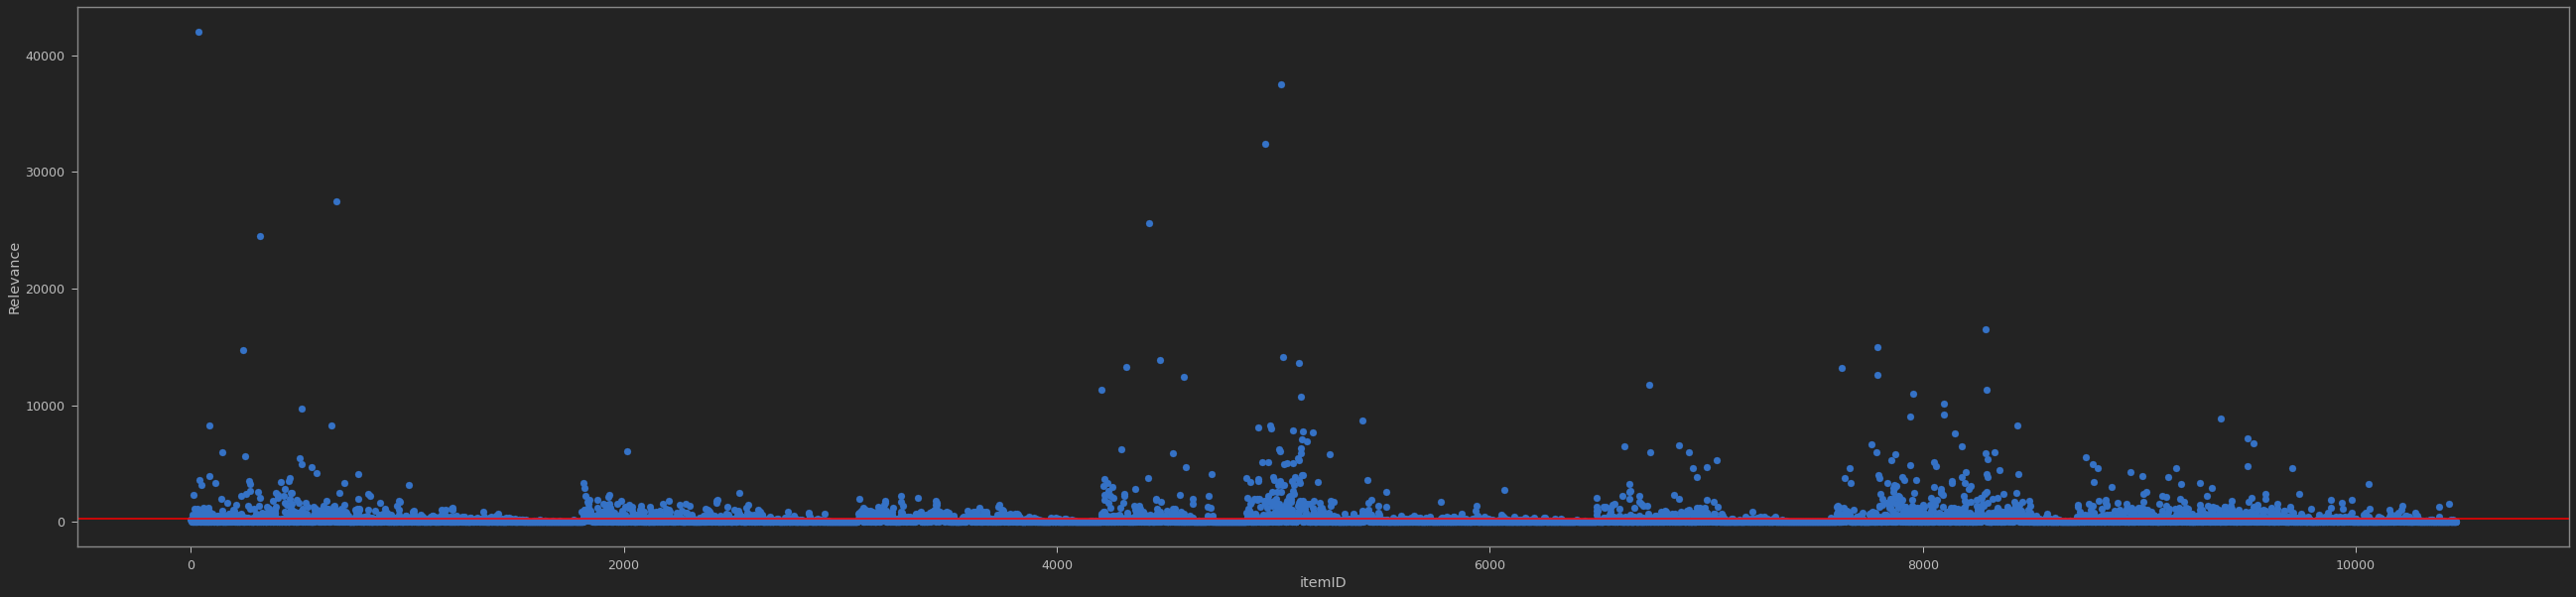

In [11]:
plt.xlabel('itemID')
plt.ylabel('Relevance')
plt.scatter(weighted_relevances['itemID'], weighted_relevances['itemRelevance'])
plt.axhline(np.mean(weighted_relevances['itemRelevance']), color="red")

## Visual Comparison Scatter

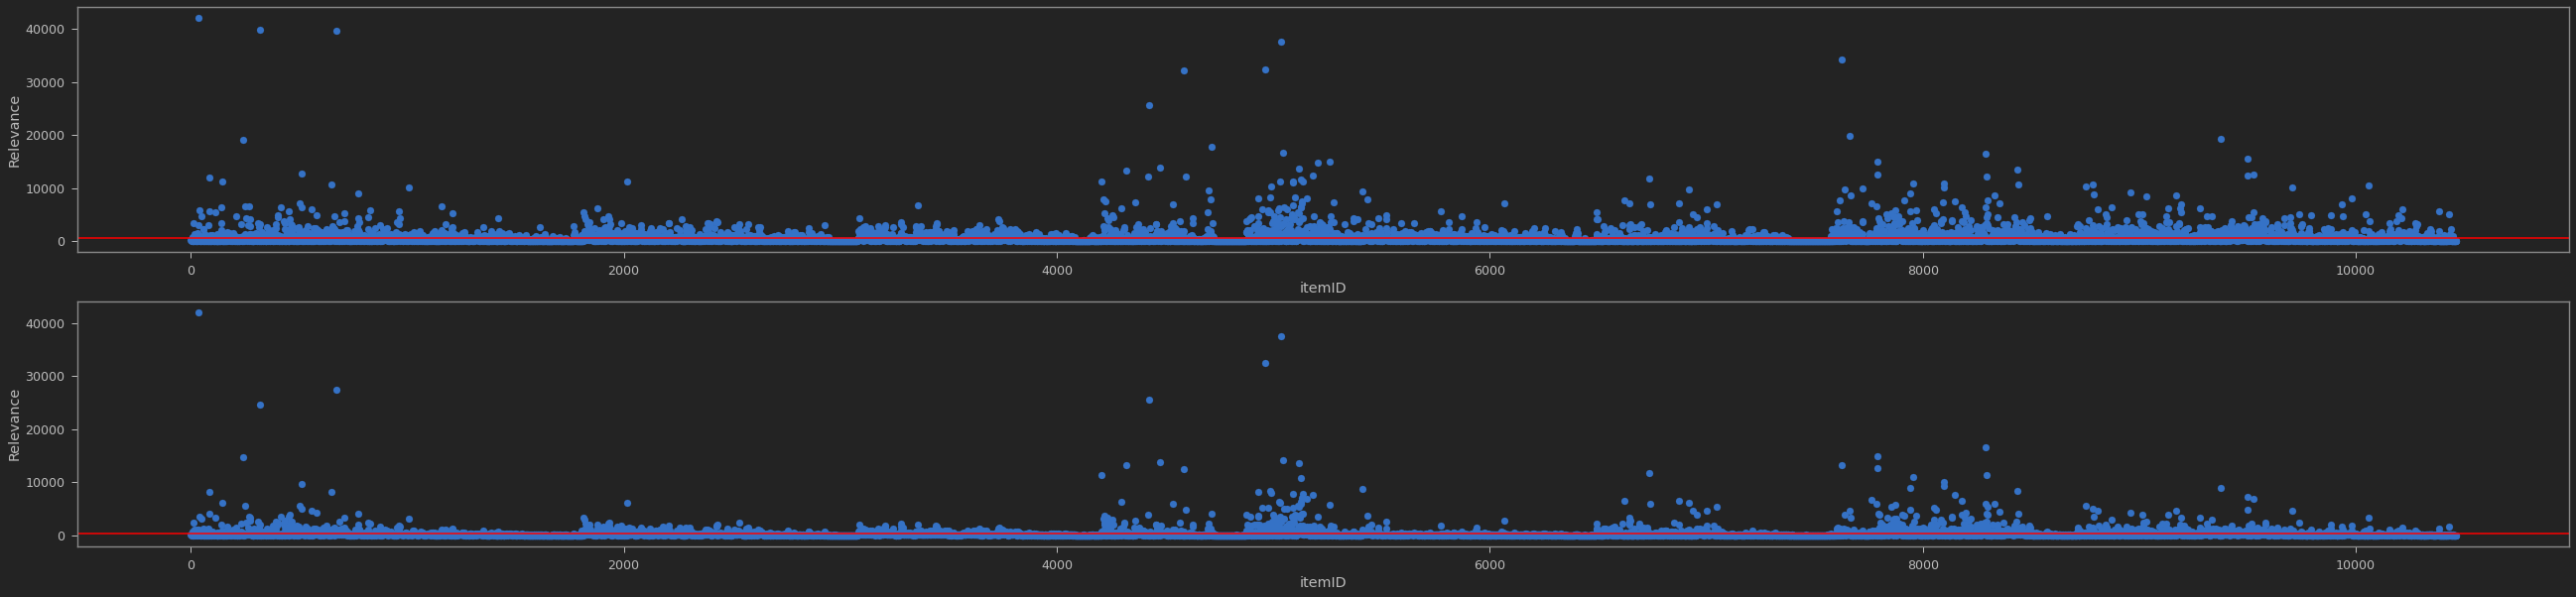

In [12]:
# Naive plot
plt.subplot(211)
plt.xlabel('itemID')
plt.ylabel('Relevance')
plt.scatter(relevances['itemID'], relevances['itemRelevance'])
plt.axhline(np.mean(relevances['itemRelevance']), color="red")

# 'Enhanced' Plot
plt.subplot(212)
plt.xlabel('itemID')
plt.ylabel('Relevance')
plt.scatter(weighted_relevances['itemID'], weighted_relevances['itemRelevance'])
plt.axhline(np.mean(weighted_relevances['itemRelevance']), color="red")

# Pareto Distribution Comparison

In [13]:
relevance_values = (relevances['itemRelevance'] / relevances['itemRelevance'].sum(
)).sort_values(ascending=False, ignore_index=True).cumsum()
weighted_relevance_values = (weighted_relevances['itemRelevance'] / weighted_relevances['itemRelevance'].sum(
)).sort_values(ascending=False, ignore_index=True).cumsum()

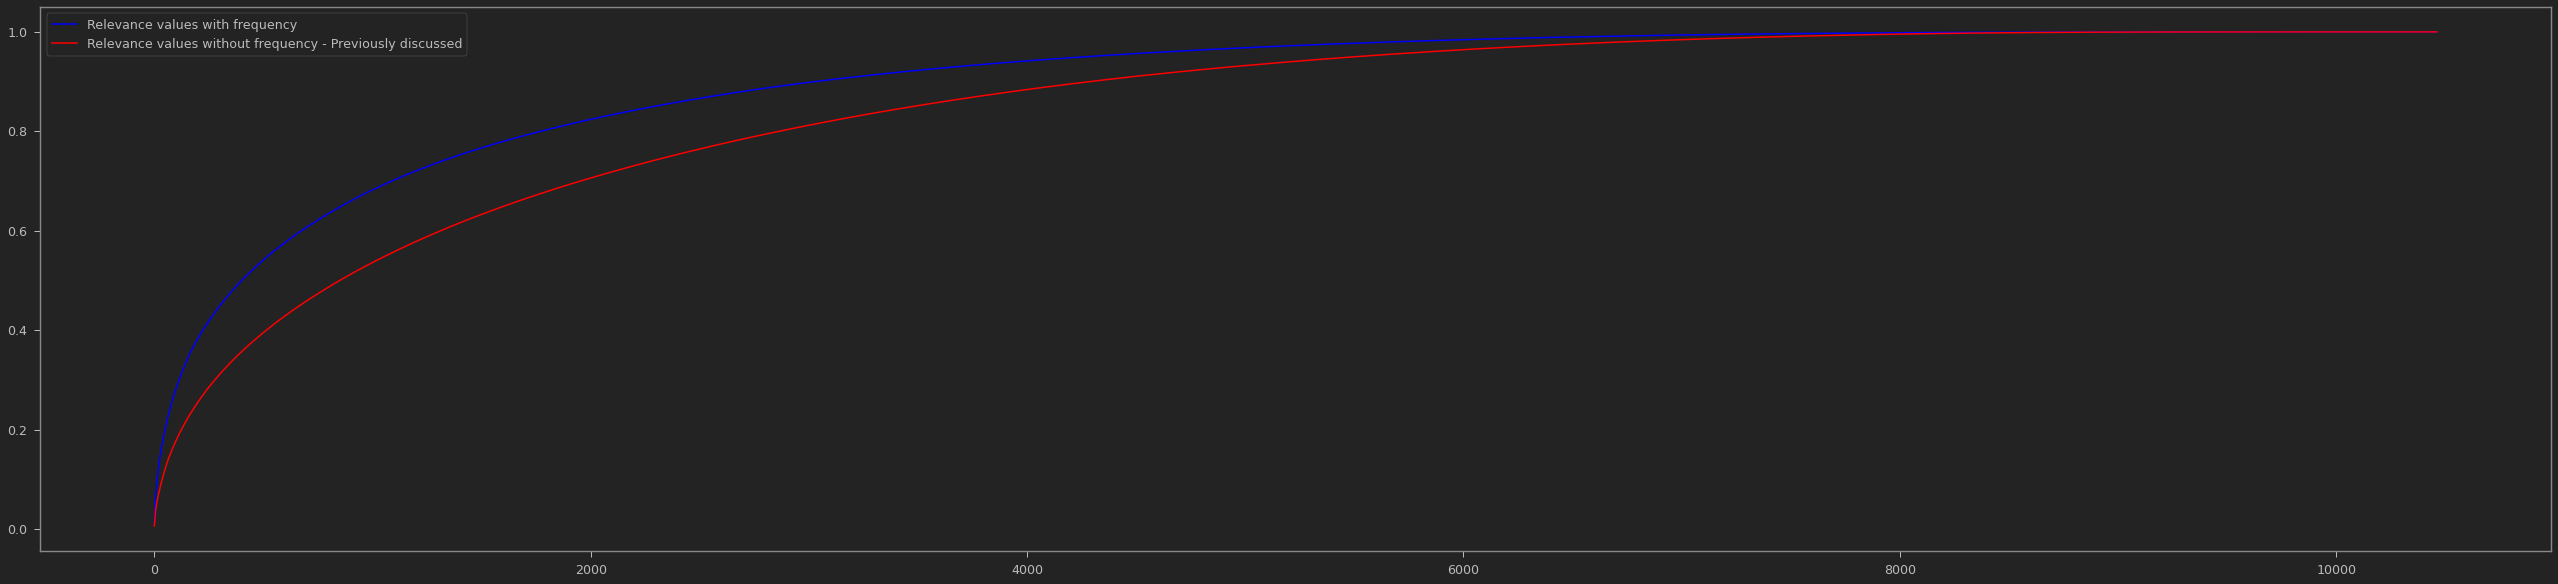

In [14]:
plt.plot(weighted_relevance_values, color='blue', label='Relevance values with frequency')
plt.plot(relevance_values, color='red', label="Relevance values without frequency - Previously discussed")
plt.legend()
plt.show()

{0: 0.013907593836217003,
 1: 0.026329482329402333,
 2: 0.0370586630965767,
 3: 0.046138559277827326,
 4: 0.05461335973116084,
 5: 0.0627319122307311,
 6: 0.06820160150698348,
 7: 0.07314366473100142,
 8: 0.0780121819963023,
 9: 0.08269848548949106,
 10: 0.08727642329977164,
 11: 0.09177129836095499,
 12: 0.09615616996381529,
 13: 0.10051711021613706,
 14: 0.10469241729270647,
 15: 0.10879161492983387,
 16: 0.11267754531808075,
 17: 0.11641442426742964,
 18: 0.12014606205086935,
 19: 0.1237691584840508,
 20: 0.12731331367033422,
 21: 0.1306515585780863,
 22: 0.1338724047819539,
 23: 0.1369275151790607,
 24: 0.1399016568935153,
 25: 0.14284227078456127,
 26: 0.14571859189110034,
 27: 0.14844777766505027,
 28: 0.15117687694293852,
 29: 0.15390383546340394,
 30: 0.15662240897038274,
 31: 0.15929438759823997,
 32: 0.16193181354811936,
 33: 0.1645163113622982,
 34: 0.16707087622966377,
 35: 0.1696052782664342,
 36: 0.17210357003467883,
 37: 0.17447872748713097,
 38: 0.17681244167098512,
 39